In [195]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

In [196]:
listing = pd.read_csv('data/prepped/lis_out.csv')

In [197]:
listing.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_about,host_listings_count,...,weekly_price_float,monthly_price_float,host_is_super_host,host_response_rate_float,review_true_score,cancel_policy_code,property_code,neighbourhood_code,room_code,zipcode_code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0000,0,0,0,0,0
1,5956968.0,6.0,44.0,83.0,189.0,22.0,14.0,19.0,40.0,1.0,...,800.0,3476.00,0.0,0.0,2.3275,2,10,13,2,15
2,1909058.0,6.0,39.0,175.0,172.0,15.0,15.0,90.0,42.0,1.0,...,575.0,2498.38,1.0,1.0,2.4354,1,10,13,2,15
3,4948745.0,6.0,32.0,23.0,167.0,81.0,0.0,42.0,44.0,1.0,...,500.0,1700.00,0.0,0.0,1.1834,2,1,13,2,9
4,4454295.0,5.0,37.0,29.0,110.0,16.0,0.0,7.0,45.0,1.0,...,800.0,2000.00,0.0,1.0,0.9506,2,10,13,1,15


In [198]:
#####  Forward Select from any Data Set using Linear Models
import warnings
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf
import statsmodels.api as sm
import time
from scipy import stats
def Forward_Select(data, response, modeltype, metric):
    """Select Variables using forward selection before building a Linear model.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response
    response: string, name of response column in data
    model_type: It accepts both "Regression" and "Classification" type problems.
    metric: the criteria improving which the variable is Selected.
          The metric must be a known metric among all Statsmodels' model metrics.

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model with an intercept
           selected by forward selection. 
           evaluated by adjusted R-squared or AIC or BIC or whatever
    selected: variables that are selected by this algorithm.
    """
    ############################################################################
    #####   CAUTION CAUTION: IF you have Scipy 1.0 version you have to do this 
    ##### This is a dumb workaround until Scipy 1.0 is patched - I should not have
    ### upgraded from scipy 0.19 to scipy 1.0 = full of bugs!![]. If you DONT
    #### have this statement then your glm.summary statement will give an ERROR
    stats.chisqprob = lambda chisq, data: stats.chi2.sf(chisq, data)
    #### For those who have Scipy 0.19 or older, you can comment out above line.
    ############################################################################
    start_time = time.time()
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    maxiter = 1000
    if metric == 'rsquared' or metric == 'rsquared_adj':
        current_score, best_new_score = 0.0, 0.0
    else:
        current_score, best_new_score = np.inf, np.inf
    iterations = 1
    if data[response].dtype == object:
        response_char = 'C(' + response + ')'
        data[response], factors = factorize_class(data[response])
    else:
        response_char = response
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            #print('Variable considered: %s' %candidate)
            if data[candidate].dtype == object:
                ### If it is a categorical variable, encode it this way
                #### In smf formula string notation, you don't have to add 1. it adds it automatically.
                if selected == []:
                    formula = "{} ~ {}".format(response_char,
                                                'C('+candidate+')')
                else:
                    formula = "{} ~ {} + {}".format(response_char,
                                            ' + '.join(selected), 'C('+candidate+')')
            else:
                formula = "{} ~ {}".format(response_char,
                                           ' + '.join(selected + [candidate]))
            if modeltype == 'Regression':
                model = smf.ols(formula, data).fit(max_iter=maxiter, disp=0)
            else:
                if len(data[response].value_counts()) > 2:
                    try:
                        model = smf.mnlogit(formula=formula, data=data).fit(max_iter=maxiter, disp=0)
                    except:
                        model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit(
                                        max_iter=maxiter, disp=0)
                else:
                    try:
                        model = smf.logit(formula=formula, data=data).fit(max_iter=maxiter, disp=0)
                    except:
                        model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit(
                                                    max_iter=maxiter, disp=0)
            try:
                score = eval('model.'+metric)
            except:
                if modeltype == 'Regression':
                    metric = 'aic'
                    print('Metric not recognized. Choosing default = %s' %metric)
                else:
                    metric = 'aic'
                    print('Metric not recognized. Choosing default = %s' %metric)
                score = eval('model.'+metric)
            iterations += 1
            scores_with_candidates.append((score, candidate))
        if metric == 'rsquared' or metric == 'rsquared_adj':
            scores_with_candidates.sort(reverse=False)
        else:
            scores_with_candidates.sort(reverse=False)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if metric == 'rsquared' or metric == 'rsquared_adj':
            if current_score < best_new_score:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
        else:
            if current_score > best_new_score:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
    tempform = []
    print('Time taken for %d iterations (minutes): %0.2f' %(iterations, (time.time()-start_time)/60))
    for eachcol in selected:
        if tempform == []:
            if data[eachcol].dtype == object:
                ### If it is a categorical variable, encode it this way
                tempform = 'C('+eachcol+')'
            else:
                tempform = eachcol
        else:
            if data[eachcol].dtype == object:
                ### If it is a categorical variable, encode it this way
                tempform = "{} + {}".format(tempform, 'C('+eachcol+')')
            else:
                tempform = "{} + {}".format(tempform, eachcol)
    ### when all is done, put the formula together ####
    formula = "{} ~ {} ".format(response_char, tempform)
    if modeltype == 'Regression':
        model = smf.ols(formula, data).fit(max_iter=maxiter, disp=0)
    else:
        if len(data[response].value_counts()) > 2:
            try:
                model = smf.mnlogit(formula=formula, data=data).fit(max_iter=maxiter, disp=0)
            except:
                model = smf.glm(formula=formula, data=data, family=sm.families.Gamma()).fit(
                                        max_iter=maxiter, disp=0)
        else:
            try:
                model = smf.logit(formula, data).fit(max_iter=maxiter, disp=0)
            except:
                model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit(
                                        max_iter=maxiter, disp=0)
    print('Score = %0.2f, Number Selected = %d\nmodel formula: %s' %(score,
                                    len(selected),formula))
    print('Time taken for Final Model (minutes): %0.2f' %((time.time()-start_time)/60))
    print(model.summary())
    return model, selected

In [199]:
listing.corr().price_float.sort_values()

longitude                        -0.678055
number_of_reviews                 0.178263
host_is_super_host                0.186259
notes                             0.199600
reviews_per_month                 0.213616
review_true_score                 0.214950
transit                           0.231930
calculated_host_listings_count    0.247494
host_about                        0.255858
ep                                0.277775
room_code                         0.278710
host_listings_count               0.281353
host_total_listings_count         0.281353
property_code                     0.286034
neighborhood_overview             0.290341
zipcode_code                      0.362277
maximum_nights                    0.366256
minimum_nights                    0.369200
id                                0.400913
neighbourhood_code                0.409354
sd                                0.415777
space                             0.426187
host_response_rate_float          0.468423
summary    

In [200]:
selected_cols = ['price_float',
                'accommodates',
                'beds',
                'bedrooms',
                'cf',
                'sd',
                'zipcode_code',
                'host_is_super_host',
                'bathrooms',
                'space',
                'minimum_nights',
                'latitude',
                'host_listings_count',
                'review_scores_rating',
                'name',
                'longitude',
                'review_true_score', 'host_response_rate_float']

temp = listing[selected_cols]

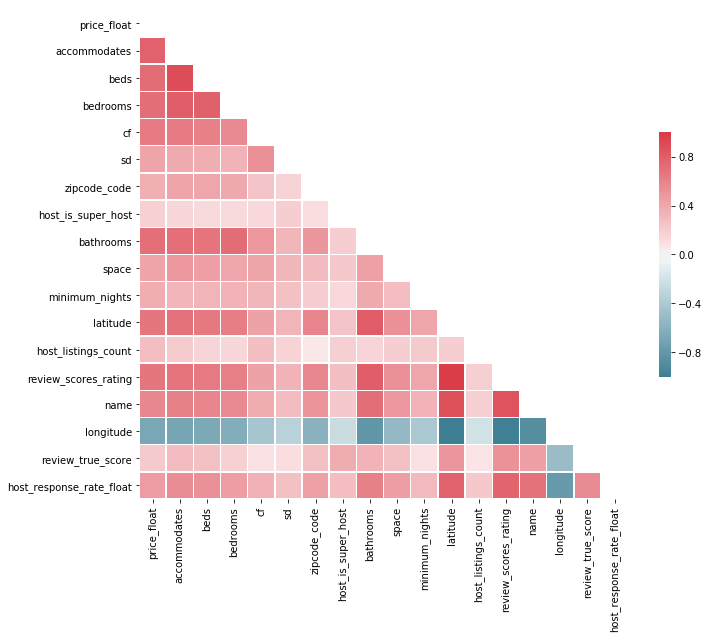

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.zeros_like(temp.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(temp.corr(), mask=mask, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

plt.show()

In [202]:
formula = ' + '.join(i for i in list(selected_cols[1:]))
formula = 'price_float ~ ' + formula

In [203]:
#mod = Forward_Select(result, 'price_float', 'Regression', 'rsquared_adj')

In [204]:
#mod.params

In [205]:
train_features, test_features, train_outcome, test_outcome = train_test_split(
    temp.drop('price_float', axis=1),
    temp.price_float,
    test_size=0.30,
    random_state=15
)

## Negative Binomial Regression

In [206]:
mod = smf.glm(formula=formula,
              data=temp,
              family=sm.families.NegativeBinomial())
mod = mod.fit()

predictions_nb = mod.predict(test_features)

nbr_score = mean_absolute_error(predictions_nb, test_outcome)
nbr_score

24.366550225380006

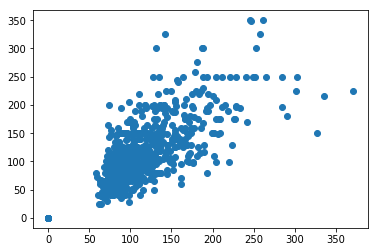

In [207]:
plt.scatter(predictions_nb, test_outcome)

## Baseline Linear Regression

In [208]:
#Baseline model
from sklearn.linear_model import LinearRegression

ls = LinearRegression()
ls.fit(train_features, train_outcome)
pred = ls.predict(test_features)

In [209]:
from sklearn.metrics import mean_absolute_error

base_lin_score = mean_absolute_error(test_outcome, pred)
base_lin_score

24.464345385731573

## K-Nearest Neighbors

In [210]:
from sklearn.neighbors import KNeighborsRegressor    # KNN regressor
from sklearn.preprocessing import StandardScaler      # scaling data
from sklearn.pipeline import make_pipeline 

#Regression Model
knn_reg = KNeighborsRegressor()

std_scaler = StandardScaler()

# Define a pipeline that uses your scaler and classifier
pipe_knn = make_pipeline(std_scaler, knn_reg)

# Define a grid to search through
param_grid_knn = {'kneighborsregressor__n_neighbors':range(10, 20), 
                  'kneighborsregressor__weights':["uniform", "distance"],
                  'kneighborsregressor__algorithm':['auto']}

# Perform a  grid search of your pipeline
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=10, scoring="neg_mean_absolute_error")

In [211]:
grid_knn.fit(train_features, train_outcome)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kneighborsregressor__n_neighbors': range(10, 20), 'kneighborsregressor__weights': ['uniform', 'distance'], 'kneighborsregressor__algorithm': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [212]:
knn_score = grid_knn.score(test_features, test_outcome)
knn_score

-23.219322167824934

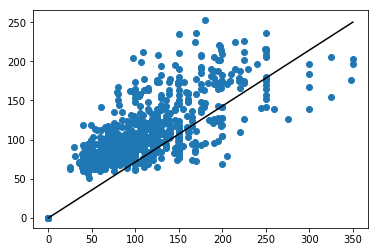

In [214]:
plt.scatter(test_outcome, grid_knn.predict(test_features))
plt.plot([0,350], [0, 250], color='k')
plt.show()

## Ridge Linear Regression

In [215]:
from sklearn.linear_model import Ridge

lin_reg = Ridge()

# Define a pipeline that uses your scaler and classifier
lin_pipe = make_pipeline(std_scaler, lin_reg)

# Define a grid to search through
param_grid_lin = {'ridge__alpha':[1],
                  'ridge__fit_intercept':[True,False],
                  'ridge__normalize':[True,False],
                  'ridge__copy_X':[True, False],
                  'ridge__solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# Perform a  grid search of your pipeline
grid_lin = GridSearchCV(lin_pipe, param_grid_lin, scoring="neg_mean_absolute_error")


In [216]:
grid_lin.fit(train_features, train_outcome)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': [1], 'ridge__fit_intercept': [True, False], 'ridge__normalize': [True, False], 'ridge__copy_X': [True, False], 'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [217]:
ridge_score = grid_lin.score(test_features, test_outcome)
ridge_score

-24.62070135871451

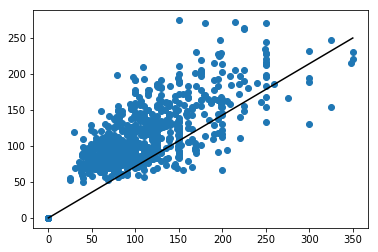

In [218]:
plt.scatter(test_outcome, grid_lin.predict(test_features))
plt.plot([0,350], [0, 250], color='k')
plt.show()

## XGBooster Regression

In [219]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

param_grid_xgb = {'n_jobs':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [5],
              'min_child_weight':[1],
              'colsample_bytree': [0.8],
              'gamma':[0.5],
              'subsample':[0.9],
              'random_state':[11],
              'n_estimators': [1000] #number of trees
              }

grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring='neg_mean_absolute_error')

In [220]:
grid_xgb.fit(train_features, train_outcome)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_jobs': [4], 'objective': ['reg:linear'], 'learning_rate': [0.05], 'max_depth': [5], 'min_child_weight': [1], 'colsample_bytree': [0.8], 'gamma': [0.5], 'subsample': [0.9], 'random_state': [11], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [221]:
xgb_score = grid_xgb.score(test_features, test_outcome)
xgb_score

-20.756329545794152

In [ ]:
sns.boxplot(x=result_NAN.total_bookings)

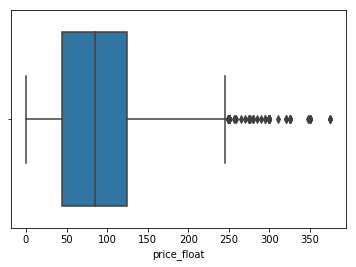

In [129]:
sns.boxplot(x=.price_float)